In [1]:
import pandas as pd


# Load the dataset into a DataFrame
df = pd.read_csv('time_series_15min_singleindex.csv', low_memory=False)

# Convert the 'utc_timestamp' column to a datetime object
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set the 'utc_timestamp' as the DataFrame index
df = df.set_index('utc_timestamp')

# Display the first few rows to show the new index
print(df.head())

# Display the DataFrame info to confirm the index data type
print(df.info())

                                 cet_cest_timestamp  \
utc_timestamp                                         
2014-12-31 23:00:00+00:00  2015-01-01T00:00:00+0100   
2014-12-31 23:15:00+00:00  2015-01-01T00:15:00+0100   
2014-12-31 23:30:00+00:00  2015-01-01T00:30:00+0100   
2014-12-31 23:45:00+00:00  2015-01-01T00:45:00+0100   
2015-01-01 00:00:00+00:00  2015-01-01T01:00:00+0100   

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   
2014-12-31 23:15:00+00:00                                 NaN   
2014-12-31 23:30:00+00:00                                 NaN   
2014-12-31 23:45:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                                 NaN   

                           AT_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:0

In [2]:
# Select the aggregate country-level columns for Germany (DE)
de_cols = [
    'DE_load_actual_entsoe_transparency',      # Actual Load (Your Target Variable)
    'DE_load_forecast_entsoe_transparency',    # Day-Ahead Forecast (Key Predictor)
    'DE_solar_generation_actual',              # Actual Solar Generation
    'DE_wind_onshore_generation_actual'        # Actual Wind Onshore Generation
]
df_de = df[de_cols].copy()

# Fill the missing values using time-based interpolation
# This method is suitable for time-series data to estimate missing points
df_de.interpolate(method='time', inplace=True)

# Check the non-null counts again to confirm that missing values have been handled
print("DataFrame Info after selecting DE data and handling missing values:")
print(df_de.info())

DataFrame Info after selecting DE data and handling missing values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201604 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Data columns (total 4 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   DE_load_actual_entsoe_transparency    201599 non-null  float64
 1   DE_load_forecast_entsoe_transparency  201599 non-null  float64
 2   DE_solar_generation_actual            201571 non-null  float64
 3   DE_wind_onshore_generation_actual     201599 non-null  float64
dtypes: float64(4)
memory usage: 7.7 MB
None


In [3]:
# Fill any remaining missing values using forward fill (ffill)
# and then backward fill (bfill) as a final clean-up step.
df_de.fillna(method='ffill', inplace=True)
df_de.fillna(method='bfill', inplace=True)

# Final check to confirm zero missing values
print("\nFinal Missing Value Check:")
print(df_de.isnull().sum())


Final Missing Value Check:
DE_load_actual_entsoe_transparency      0
DE_load_forecast_entsoe_transparency    0
DE_solar_generation_actual              0
DE_wind_onshore_generation_actual       0
dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_7100\3089314127.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_de.fillna(method='ffill', inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_7100\3089314127.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_de.fillna(method='bfill', inplace=True)


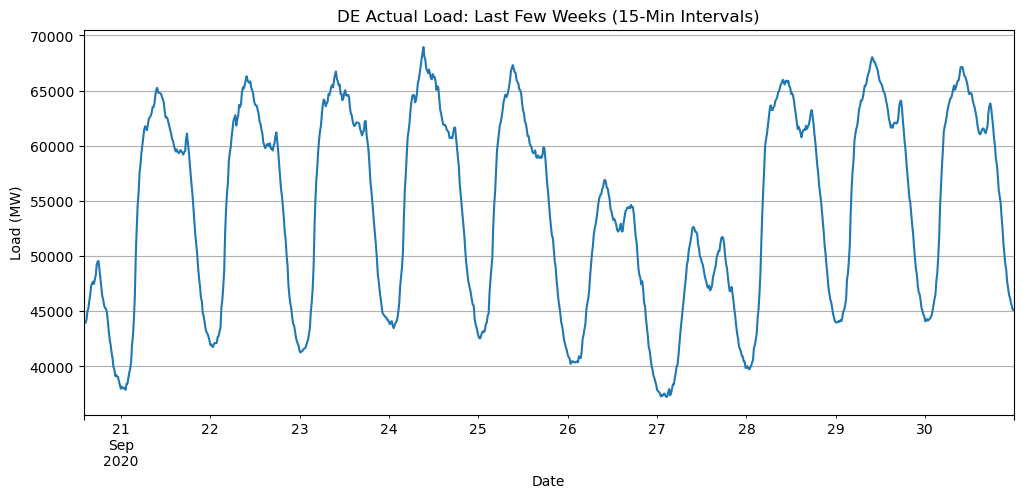

In [4]:
import matplotlib.pyplot as plt

# Select the last few weeks of the data (e.g., last 1000 data points)
recent_load = df_de['DE_load_actual_entsoe_transparency'].tail(1000)

plt.figure(figsize=(12, 5))
recent_load.plot()
plt.title('DE Actual Load: Last Few Weeks (15-Min Intervals)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.show()

In [5]:
# Save the clean DataFrame in the highly-efficient Parquet format
import pandas as pd

# Define the local path using a raw string literal
file_path_parquet = r"F:\LJMU THESIS\Topic 2 Papers and Supporting Documents\SEASONAL-HYBRID-MODELS-WITH-EXPLAINABLE-AI-FOR-SHORT-TERM-ENERGY-LOAD-FORECASTING\opsd_de_15min_clean.parquet"


# This should now load instantly
df_de = pd.read_parquet(file_path_parquet)

print("Clean data loaded successfully in seconds! Ready for STL.")
print(df_de.info())

Clean data loaded successfully in seconds! Ready for STL.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201604 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Data columns (total 4 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   DE_load_actual_entsoe_transparency    201604 non-null  float64
 1   DE_load_forecast_entsoe_transparency  201604 non-null  float64
 2   DE_solar_generation_actual            201604 non-null  float64
 3   DE_wind_onshore_generation_actual     201604 non-null  float64
dtypes: float64(4)
memory usage: 7.7 MB
None


In [6]:
# 1) confirm timezone awareness
print('tz:', df_de.index.tz)

# 2) check inferred regular frequency
import pandas as pd
print('inferred freq:', pd.infer_freq(df_de.index))

# 3) inspect largest gap (and count >4h gaps)
gaps = df_de.index.to_series().diff()
print('max gap:', gaps.max())
print('num gaps > 4 hours:', (gaps > pd.Timedelta('4H')).sum())


tz: UTC
inferred freq: 15min
max gap: 0 days 00:15:00
num gaps > 4 hours: 0


C:\Users\admin\AppData\Local\Temp\ipykernel_7100\105002127.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  print('num gaps > 4 hours:', (gaps > pd.Timedelta('4H')).sum())


## **Seasonal-Trend Decomposition (STL)**

--- STL Decomposition Started ---
--- STL Decomposition Completed in 735.54 seconds ---


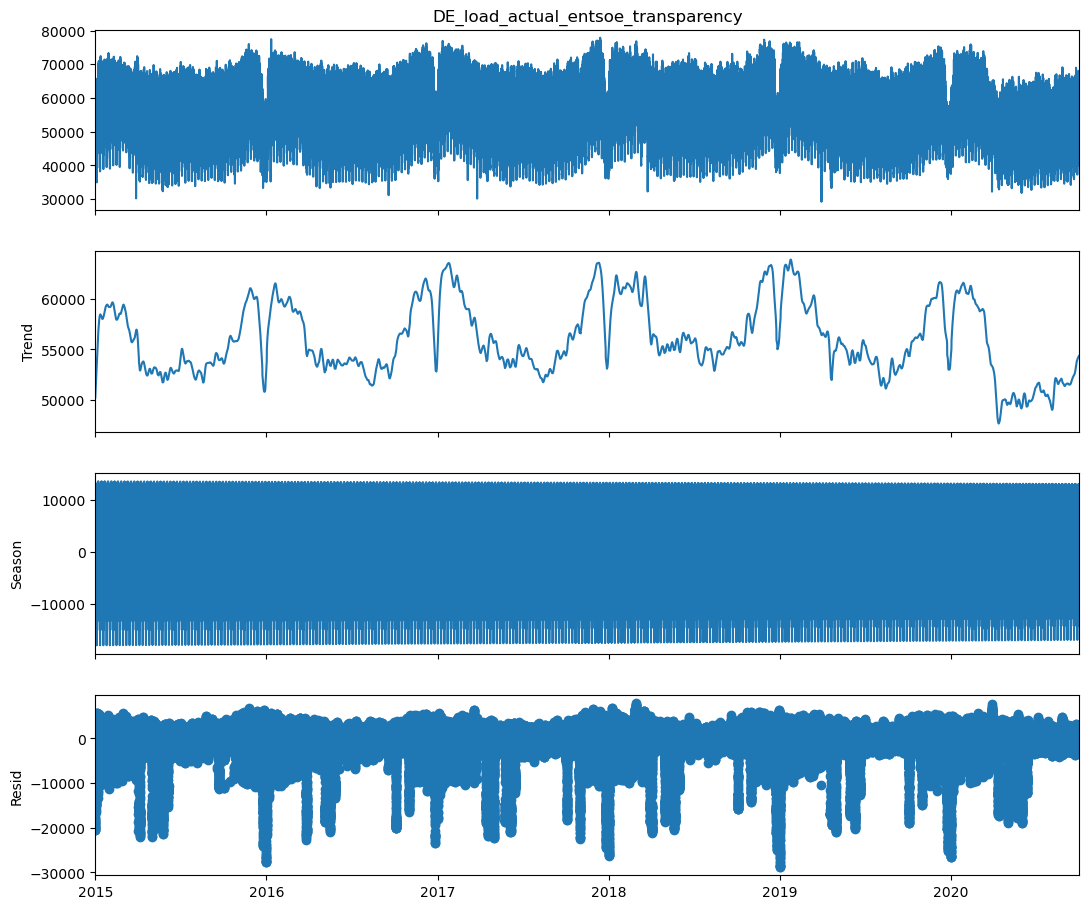

In [7]:
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Assuming df_de is loaded
load_series = df_de['DE_load_actual_entsoe_transparency']

print("--- STL Decomposition Started ---")
start_time = time.time() # Start the timer

# Corrected STL decomposition with seasonal=671
stl = STL(load_series, seasonal=671, robust=True, period=672) 
res = stl.fit()

end_time = time.time() # Stop the timer

# Calculate and display the execution time
execution_time = end_time - start_time
print(f"--- STL Decomposition Completed in {execution_time:.2f} seconds ---")


# Plot the decomposed components
fig = res.plot()
fig.set_size_inches(12, 10)
plt.show()

## **Feature Engineering: Finalizing the Dataset**

In [8]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.seasonal import STL
import pickle # Used for saving/loading the complex 'res' object

# --- Configuration ---
# NOTE: Define a file path for the STL results on your local machine
STL_CACHE_FILE = r'F:\LJMU THESIS\Topic 2 Papers and Supporting Documents\SEASONAL-HYBRID-MODELS-WITH-EXPLAINABLE-AI-FOR-SHORT-TERM-ENERGY-LOAD-FORECASTING\stl_results.pkl'
file_path_parquet = r'F:\LJMU THESIS\Topic 2 Papers and Supporting Documents\SEASONAL-HYBRID-MODELS-WITH-EXPLAINABLE-AI-FOR-SHORT-TERM-ENERGY-LOAD-FORECASTING\opsd_de_15min_clean.parquet'

# --- 1. Load Clean Data ---
df_de = pd.read_parquet(file_path_parquet)
load_series = df_de['DE_load_actual_entsoe_transparency']
TARGET_COLUMN = 'DE_load_actual_entsoe_transparency'
TARGET_RESIDUAL_COLUMN = 'residual'

# --- 2. STL Decomposition (Conditional Execution) ---
res = None

# Check if the STL results file exists
if os.path.exists(STL_CACHE_FILE):
    # Load the results instantly (Fast Path)
    with open(STL_CACHE_FILE, 'rb') as f:
        res = pickle.load(f)
    print("--- STL Decomposition Loaded from Cache (Instantaneous) ---")
else:
    # Recalculate and save the results (Slow Path, runs only once)
    print("--- STL Decomposition Started (Will take ~12 minutes) ---")
    stl = STL(load_series, seasonal=671, robust=True, period=672) 
    res = stl.fit() 
    
    # Save the result object for future runs
    with open(STL_CACHE_FILE, 'wb') as f:
        pickle.dump(res, f)
    print(f"--- STL Decomposition Completed and Saved to: {STL_CACHE_FILE} ---")


# --- 3. Integrate STL Components & Create Features ---

# Integrate STL components back into the DataFrame
df_de['trend'] = res.trend
df_de['seasonal'] = res.seasonal
df_de['residual'] = res.resid

# Create Time-Series Features
df_de['hour'] = df_de.index.hour
df_de['minute'] = df_de.index.minute
df_de['day_of_week'] = df_de.index.dayofweek
df_de['day_of_year'] = df_de.index.dayofyear
df_de['month'] = df_de.index.month
df_de['year'] = df_de.index.year
df_de['is_weekend'] = (df_de['day_of_week'] >= 5).astype(int)
df_de['time_of_day_15min'] = df_de['hour'] * 4 + df_de['minute'] / 15 

# Create Lag Features
for lag in [96, 672]:
    df_de[f'residual_lag_{lag}'] = df_de[TARGET_RESIDUAL_COLUMN].shift(lag)
    df_de[f'load_actual_lag_{lag}'] = df_de[TARGET_COLUMN].shift(lag)

# Final Clean-up and Summary
df_de.dropna(inplace=True)

FEATURE_COLS = [
    'DE_load_forecast_entsoe_transparency', 'DE_solar_generation_actual',
    'DE_wind_onshore_generation_actual', 'hour', 'minute', 'day_of_week', 
    'day_of_year', 'month', 'year', 'is_weekend', 'time_of_day_15min',
    'residual_lag_96', 'residual_lag_672', 'load_actual_lag_96', 'load_actual_lag_672' 
]

print("\n--- Feature Engineering Complete: Final Dataset Summary ---")
print(f"Total Features (Predictors): {len(FEATURE_COLS)}")
print(f"Total Observations (Rows): {len(df_de)}")
print(f"Data starts at: {df_de.index[0]}")
print(df_de.tail())
print(df_de[FEATURE_COLS + [TARGET_RESIDUAL_COLUMN]].info())

--- STL Decomposition Loaded from Cache (Instantaneous) ---

--- Feature Engineering Complete: Final Dataset Summary ---
Total Features (Predictors): 15
Total Observations (Rows): 200932
Data starts at: 2015-01-07 23:00:00+00:00
                           DE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2020-09-30 22:45:00+00:00                            46229.48   
2020-09-30 23:00:00+00:00                            45792.82   
2020-09-30 23:15:00+00:00                            45471.18   
2020-09-30 23:30:00+00:00                            45119.89   
2020-09-30 23:45:00+00:00                            45119.89   

                           DE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2020-09-30 22:45:00+00:00                              45971.68   
2020-09-30 23:00:00+00:00                              45303.45   
2020-09-30 23:15:00+00:00                      

Proceeding with the Rolling-Origin Cross-Validation (ROCV) split and then set up the STL + LightGBM Hybrid Model



## Execute ROCV Data Split

In [9]:
# --- 1. Define Target and Features ---
# NOTE: df_de, X, and Y variables are now ready from the previous cells.
TARGET_RESIDUAL_COLUMN = 'residual'
FEATURE_COLS = [
    'DE_load_forecast_entsoe_transparency', 'DE_solar_generation_actual',
    'DE_wind_onshore_generation_actual', 'hour', 'minute', 'day_of_week', 
    'day_of_year', 'month', 'year', 'is_weekend', 'time_of_day_15min',
    'residual_lag_96', 'residual_lag_672', 'load_actual_lag_96', 'load_actual_lag_672' 
]

X = df_de[FEATURE_COLS]
Y_resid = df_de[TARGET_RESIDUAL_COLUMN]
Y_load = df_de['DE_load_actual_entsoe_transparency'] # Keep the original load for final error calculation

# --- 2. Define Split Point (80% Train / 20% Test for Time Series) ---
# Total observations are 200,932
split_point = int(len(df_de) * 0.8)

# --- 3. Apply the Split (ROCV Principle) ---
# .iloc[] ensures we split by position, maintaining time order.
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
Y_resid_train, Y_resid_test = Y_resid.iloc[:split_point], Y_resid.iloc[split_point:]
Y_load_test = Y_load.iloc[split_point:] # Only need the actual load for the test period

# --- 4. Display Split Confirmation ---
print(f"Total Observations: {len(df_de)}")
print(f"--- Rolling Origin Split Details (80/20) ---")
print(f"Train Set Size (80%): {len(X_train)} samples, up to {X_train.index[-1].date()}")
print(f"Test Set Size (20%): {len(X_test)} samples, starting from {X_test.index[0].date()}")
print(f"Validation Horizon (Time Span): {X_test.index[-1] - X_test.index[0]}")

Total Observations: 200932
--- Rolling Origin Split Details (80/20) ---
Train Set Size (80%): 160745 samples, up to 2019-08-09
Test Set Size (20%): 40187 samples, starting from 2019-08-09
Validation Horizon (Time Span): 418 days 14:30:00


## STL + LightGBM Hybrid Model Training

In [12]:
import lightgbm as lgb
import time

print("--- Starting STL + LightGBM Hybrid Model Training ---")
start_time = time.time()

# 1. Initialize the LightGBM Regressor
# We use default parameters for the initial benchmark run.
# The objective is 'regression' since we are predicting continuous residual values.
lgbm_model = lgb.LGBMRegressor(
    objective='regression', 
    metric='mae',  # Use Mean Absolute Error for training
    n_estimators=1000, 
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=-1 # Suppress warnings/output
)

# 2. Train the Model on Residuals
# The model uses all the engineered features (X_train) to predict the Residual (Y_resid_train)
lgbm_model.fit(
    X_train, 
    Y_resid_train
)

end_time = time.time()
training_duration = end_time - start_time

print(f"Training Complete in {training_duration:.2f} seconds.")
print("--- Model Benchmarking is Ready ---")

--- Starting STL + LightGBM Hybrid Model Training ---
Training Complete in 1.53 seconds.
--- Model Benchmarking is Ready ---
